# Ensembale Mode here
Combine all the sub-model with Bagging method

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy
import json
import seaborn as sns
from collections import namedtuple
from sklearn.base import TransformerMixin
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
import joblib
import matplotlib.pyplot as plt

### Figure the basic value

In [4]:
model_path = 'Choesn_model/'
configure_file_path = 'Choesn_model/Configuration.json'

TRAINFILE = 'keyword.csv'
TESTFILE = 'key_word_test.csv'
boolean = 'True'

## Define the MODEL object

In [5]:
class Model(object):

    def  __init__(self, model, name, test_set, topic, is_preprocess, level):
        self.model = model
        self.name = name
        self.test_set = test_set
        self.topic = topic
        self.is_preprocess = is_preprocess
        self.level = level

    def show(self):
        print(
            self.name,'\t',
            self.test_set,'\t',
            self.topic,'\t',
            self.is_preprocess,'\t',
            self.level
        )

    def predict(self, x):
        return self.model.predict(x)

    def predict_proba(self, x):
        return self.model.predict_proba(x)
        


## Load the model detail from json figuration file

In [6]:
def load_configuration_to_model(file_path):
    with open(configure_file_path, 'r') as json_fp:
        configuration = json.load(json_fp)

    layer_1 = []
    layer_2 = []
    for model_figure in configuration:
        # read the figure
        model_file = joblib.load(model_path + model_figure['model_name'])
        name = model_figure['model_name']
        test_set = model_figure['test_set']
        topic = model_figure['topic']
        is_preprocess = boolean == model_figure['preprocess']
        level = int(model_figure['level'])

        # load to model list
        model = Model(model_file, name, test_set, topic, is_preprocess, level)

        if level == 1:
            layer_1.append(model)
        else:
            layer_2.append(model)

    return [layer_1, layer_2]
    

## Prepare the testing data and preprocess vector

In [7]:
def get_vector(column_name):
    '''
    df                      str: The train df
    fit_column              str: The column for vector to fit

    Return: (Vectorizer Object)
            Vectorizer of current column
    '''
    train_df = pd.read_csv(TRAINFILE)

    # prepare the tranform vector
    vector = TfidfVectorizer().fit(train_df[column_name])

    return vector

def preprocess(df, column_name_list):
    '''
    This function to use to prepare all the data for ensemble system running
    including RAW data and Vector-preprocess data

    Return: (Dict object)
            A after preprocessing data dict, it order by column_name_list
        
            ext:
            Input: column_name_list: ['key_word_100', 'article_words']
            Output: test_data_dict: test_data_dict['key_word_100'] --> key_word_100
                                    test_data_dict['article_words'] -> article_words
                                    test_data_dict['raw']          --> original data
    '''

    test_data_dict = {}

    # first add original data
    test_data_dict['raw'] = df

    vector = get_vector('article_words')
    
    for column in column_name_list:
        en_data = vector.transform(df[column])
        test_data_dict[str(column)] = en_data

    # for special data, add it by manul
    vector = get_vector('key_word_100')
    test_data_dict['key_word_100_1'] = vector.transform(df['key_word_100'])

    return test_data_dict


In [8]:
df = pd.read_csv(TESTFILE)
dict_data = preprocess(df, ['key_word_100', 'article_words'])

## Brad's work

In [9]:
model_list_1, model_list_2 = load_configuration_to_model(configure_file_path)
print([i.show() for i in model_list_1],[i.show() for i in model_list_2])

svm_ir_clf.joblib 	 key_word_100_1 	 ['IRRELEVANT'] 	 True 	 1
rel_clf_tfidf_NB.joblib 	 article_words 	 ['IRRELEVANT'] 	 False 	 1
tfidf_logi_pipe.joblib 	 key_word_50 	 ['ARTS CULTURE ENTERTAINMENT', 'DOMESTIC MARKETS', 'SPORTS', 'SHARE LISTINGS', 'FOREX MARKETS', 'DEFENCE'] 	 False 	 2
clf_NB_1.joblib 	 key_word_50 	 ['SHARE LISTING', 'DOMESTIC MARKETS', 'ARTS CULTURE ENTERTAINMENT', 'SPORTS', 'DEFENCE', 'FOREX MARKETS', 'SCIENCE'] 	 False 	 2
clf_NB_2.joblib 	 key_word_100 	 ['SHARE LISTING', 'DOMESTIC MARKETS', 'SPORTS', 'HEALTH', 'MONEY', 'DEFENCE'] 	 False 	 2
clf_NB_3.joblib 	 key_word_50 	 ['BIOGRAPHIES PERSONALITIES PEOPLE'] 	 False 	 2
svm_proba_1.joblib 	 key_word_100 	 ['DOMESTIC MARKETS', 'SHARE LISTINGS', 'ARTS CULTURE ENTERTAINMENT', 'SPORTS', 'DEFENCE', 'FOREX MARKETS', 'BIOGRAPHIES PERSONALITIES PEOPLE'] 	 True 	 2
svm_proba_2.joblib 	 article_words 	 ['DOMESTIC MARKETS', 'SPORTS', 'FOREX MARKETS', 'HEALTH'] 	 True 	 2
1_article_words.model 	 article_words 	 ['SPORTS'

In [10]:
topic_encode = dict()
topic_decode = dict()

topic_list = list(set(df['topic']))
topic_list.sort()
for num, topic in enumerate(topic_list):
    topic_decode[num] = topic
    topic_encode[topic] = num
print(topic_encode)
print(topic_decode)

SAMPLE_SIZE = len(df)

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
{0: 'ARTS CULTURE ENTERTAINMENT', 1: 'BIOGRAPHIES PERSONALITIES PEOPLE', 2: 'DEFENCE', 3: 'DOMESTIC MARKETS', 4: 'FOREX MARKETS', 5: 'HEALTH', 6: 'IRRELEVANT', 7: 'MONEY MARKETS', 8: 'SCIENCE AND TECHNOLOGY', 9: 'SHARE LISTINGS', 10: 'SPORTS'}


In [11]:
Vote = namedtuple("Vote", "model cate proba")

In [12]:
def vote_proba(votes, topic_dict):
    cate_count = len(topic_dict)

    column_names = ['predict', 'mean_proba', 'models', 'probas']
    df = pd.DataFrame(columns = column_names)

    for num, sample in enumerate(votes): 
        # vote_list to count vote, init with 11 zeros
        vote_list = [[] for _ in range(cate_count)]
        vote_probas = [[] for _ in range(cate_count)]
        for vote in sample:
            vote_list[vote.cate].append(vote.model)
            vote_probas[vote.cate].append(vote.proba)
           
        vote_count = [len(cate_list) for cate_list in vote_list]
        vote_proba_mean = [0 for _ in range(cate_count)]
        for i in range(cate_count):
            if len(vote_probas[i]) > 0:
                vote_proba_mean[i] = sum(vote_probas[i])/len(vote_probas[i])
            
        # get category chosen by vote
        max_vote = max(vote_count)
        
        # no vote
        if max_vote == 0:
            res = [None, None, None, None]
        else:
            # check count
            # if draw vote, check proba
            if vote_list.count(max_vote) > 1:
                chosen_cate = vote_proba_mean.index(max(vote_proba_mean))

            # if not draw
            else:
                chosen_cate = vote_count.index(max_vote)

            # append to result DataFrame
            res = [topic_dict[chosen_cate], vote_proba_mean[chosen_cate], vote_list[chosen_cate], vote_probas[chosen_cate]]
        new_row = pd.Series(res, index=column_names)
        df = df.append(new_row, ignore_index=True)
        
    return df

In [13]:
def irre_vote(model_list, sample_size):
    all_votes = [[] for _ in range(sample_size)]
    for clf in model_list:
        if clf.name != 'best_logi.joblib' and clf.name != 'svm_ir_clf.joblib':
            print(clf.name)
            if clf.is_preprocess is True:
                test_x = dict_data[clf.test_set]
            else:
                test_x = dict_data['raw'][clf.test_set]
            y_pred = clf.model.predict(test_x)
            y_pred_proba = clf.model.predict_proba(test_x)
            print(y_pred)
            for i in range(sample_size):
                cate, proba = y_pred[i], y_pred_proba[i]

                clf_name = clf.name.split('.')[0]
                # create namedtuple (model_name, category, category_proba)
                all_votes[i].append(Vote(clf_name, cate, proba[cate]))
    topic_dict = {0: 'IRRELEVANT', 1: 'RELEVANT'}
    return vote_proba(all_votes, topic_dict)

In [14]:
irre_df = irre_vote(model_list_1, SAMPLE_SIZE)

rel_clf_tfidf_NB.joblib
[0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0
 0 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1
 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0
 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0
 0 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0
 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1
 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0
 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1
 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0
 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1
 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1
 

In [15]:
irre_df

,predict,mean_proba,models,probas
0,IRRELEVANT,1.00000,[rel_clf_tfidf_NB],[1.0]
1,IRRELEVANT,1.00000,[rel_clf_tfidf_NB],[1.0]
2,RELEVANT,1.00000,[rel_clf_tfidf_NB],[1.0]
3,IRRELEVANT,1.00000,[rel_clf_tfidf_NB],[1.0]
4,IRRELEVANT,1.00000,[rel_clf_tfidf_NB],[1.0]
...,...,...,...,...
495,IRRELEVANT,1.00000,[rel_clf_tfidf_NB],[1.0]
496,RELEVANT,1.00000,[rel_clf_tfidf_NB],[1.0]
497,RELEVANT,1.00000,[rel_clf_tfidf_NB],[1.0]
498,RELEVANT,1.00000,[rel_clf_tfidf_NB],[1.0]


In [16]:
def cate_vote(model_list, sample_size, irre_res, truth):
    
    column_names = ['label', 'predict', 'mean_proba', 'models', 'probas']
    final_df = pd.DataFrame(columns = column_names)
    
    all_votes = [[] for _ in range(sample_size)]
    for clf in model_list:
        print(clf.name)
        if clf.name != 'svm_proba_1.joblib' and clf.name != 'svm_proba_2.joblib':
            if clf.is_preprocess is True:
                test_x = dict_data[clf.test_set]
            else:
                test_x = dict_data['raw'][clf.test_set]
            y_pred = clf.model.predict(test_x)
            y_pred_proba = clf.model.predict_proba(test_x)
            print(y_pred)
            for i in range(sample_size):
                cate, proba = y_pred[i], y_pred_proba[i]
                if topic_decode[cate] in clf.topic:
                                
                    clf_name = clf.name.split('.')[0]

                    all_votes[i].append(Vote(clf_name, cate, proba[cate]))
    rela_res = vote_proba(all_votes, topic_decode)
    for i in range(sample_size):
        if irre_res['predict'].iloc[i] == 'IRRELEVANT':
            final_res = [truth[i]] + irre_res.iloc[i].tolist()
        else:
            final_res = [truth[i]] + rela_res.iloc[i].tolist()
        new_row = pd.Series(final_res, index=column_names)
        final_df = final_df.append(new_row, ignore_index=True)

    return final_df

In [17]:
res_df = cate_vote(model_list_2, SAMPLE_SIZE, irre_df, df['topic'])

tfidf_logi_pipe.joblib
[ 6  6  7  3  6  4  2 10  7  6  6  6 10  6  3  7  6  9  3 10  4  7  6  6
  7  1  6  6  4  4  4  7  7  7  6 10  3  2  4  0 10  7  6  6  3  6  7  4
  6  4  4  3  7  4  7  0  6  6  2  4  7  9  6  7  4  6  4 10 10  4  7  4
 10 10  1  2  4  6  2 10  9  6  7  4  6  7  7  4  7  6  6  6  4  7  6 10
 10  6  7  7  9  7  6  0  9  7  2 10  5 10  9  8  4  9  6  2  8  7  6 10
  8  6  7  6  4  7  7  2  5 10  3  4  6  4  6  6  6  7  6  3  7  6  3  6
  3  6  7  6  6  4  6  9 10  6  9 10 10  6  4  1  5 10 10  6  7  9  9  9
  6  6  4  4  6  6  6  7  7  4  6  7  3  4  7  9  7  6  6  9  6  6  7  6
  4 10 10  4  3  6  6  6 10  4  0  4  9  2  7  7  7  7  4  9  2  7  9  6
  6  4  6  0  2  6  7  6  4  6  9  6  7  6  2  6  4  4  5 10  7 10  2  4
  4  6  4  6  6  7  9  4  7  3  7 10  7 10  7  6  0  5  6 10  7  3 10  1
  7  7  3  1  7  2  6  4  2 10  6  4  6  6  7  3  2 10  1  7  6  4 10  8
  0  1 10  7  6  6  6  3  1  4  6 10 10  6  7  6  7  7  5  6 10  5 10  6
 10  6  1  7 10 10  6  7 10 

In [18]:
# res_df['predict'].apply(lambda x: 'IRRELEVANT' if x is None)
res_df.loc[res_df.predict.isnull()] = 'IRRELEVANT'

Classification Report:
                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.40      0.67      0.50         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.67      0.27      0.38        15
                         DEFENCE       0.67      0.31      0.42        13
                DOMESTIC MARKETS       0.00      0.00      0.00         2
                   FOREX MARKETS       0.49      0.93      0.64        43
                          HEALTH       0.71      0.36      0.48        14
                      IRRELEVANT       0.84      0.95      0.89       289
                   MONEY MARKETS       0.00      0.00      0.00        51
          SCIENCE AND TECHNOLOGY       0.00      0.00      0.00         3
                  SHARE LISTINGS       0.00      0.00      0.00         7
                          SPORTS       0.91      0.97      0.94        60

                        accuracy                           0.78       500
             

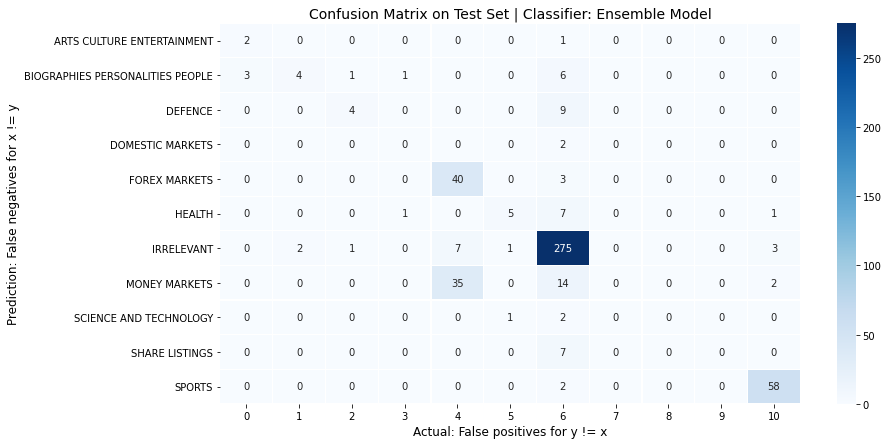

In [19]:
def report(test_y, y_pred):
    global topic_list

    print(f"Classification Report:\n{classification_report(test_y, y_pred)}")
#     print("The scores for each topic is:")
#     scores_for_topics(df_test,topics,model,le)
    conf_matrix = confusion_matrix(test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,7))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=topic_list,
#                 xticklabels=topic_list,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: Ensemble Model", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()

report(res_df['label'], res_df['predict'])

SCIENCE AND TECHNOLOGY accuarcy is:				 0.0
HEALTH accuarcy is:				 0.35714285714285715
ARTS CULTURE ENTERTAINMENT accuarcy is:				 0.6666666666666666
DOMESTIC MARKETS accuarcy is:				 0.0
SPORTS accuarcy is:				 0.9666666666666667
FOREX MARKETS accuarcy is:				 0.9302325581395349
BIOGRAPHIES PERSONALITIES PEOPLE accuarcy is:				 0.26666666666666666
MONEY MARKETS accuarcy is:				 0.0
SHARE LISTINGS accuarcy is:				 0.0
IRRELEVANT accuarcy is:				 0.9515570934256056
DEFENCE accuarcy is:				 0.3076923076923077


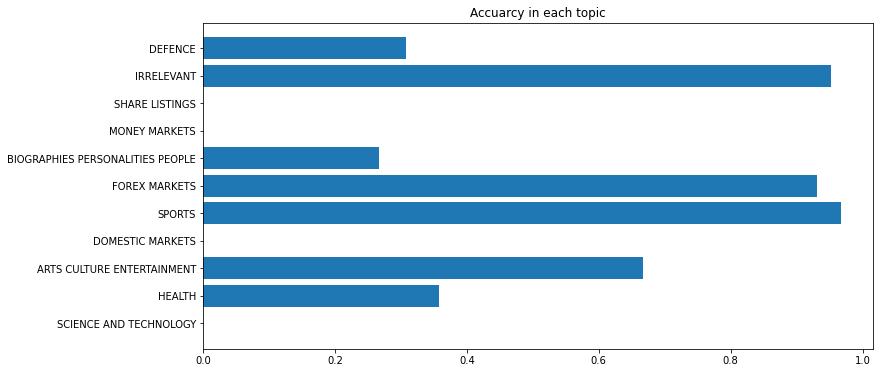

In [29]:
def evaluate(res_df, y_true_label, y_pred_label):
    '''
    Here is for the evaluate the ensamble model

    Input: (DataFrame Object) Should be result of the prediction
    Output: 
    '''

    report = []
    topic_list = list(set(res_df[y_true_label]))
    for topic in topic_list:
        test_df = res_df[res_df[y_true_label] == topic]
        accuarcy = metrics.accuracy_score(test_df[y_true_label], test_df[y_pred_label])
        print(topic,'accuarcy is:\t\t\t\t', accuarcy)
        report.append(accuarcy)

    #plt.style.use('ggplot')
    figure = plt.figure(figsize=(12,6))
    #plt.xticks(rotation=90)
    plt.title('Accuarcy in each topic')
    plt.barh(topic_list, report)

    plt.show()

evaluate(res_df, 'label', 'predict')
#list(set(res_df['label']))